# daWUAP Hydrologic Modeling Demo

**Author:** K. Arthur Endsley and Marco Maneta  
**Date:** July 2020

This is just one of many daWUAP interactive demos. See also:

- [Hydrologic Modeling Demo](https://www.umt.edu/hydro-econ-ag/crop-water/demo_hydrology.html)
- [Economic Modeling with Positive Mathematical Programming (PMP)](https://www.umt.edu/hydro-econ-ag/crop-water/demo_econ_pmp.html)
- [Economic Modeling with Stochastic Data Assimilation](https://www.umt.edu/hydro-econ-ag/crop-water/demo_econ_stochastic.html)

## Introduction

This notebook demonstrates how to use daWUAP to set up and run a hydrologic model for estimating streamflow, snowmelt, and evapotranspiration in a watershed. This demonstration covers:

- How to **generate a hydrologic network** from ESRI Shapefiles spatially defining the stream network and sub-basins (catchments).
- **Running the hydrologic model** for the defined network.
- Examining and plotting **spatially and temporally explicit outputs of the hydrologic model,** including streamflow time series and maps of snowmelt.

**Table of Contents**

1. [**Setup and Data Preparation**](#Setup-and-Data-Preparation)  
1. [**Generating a Hydrologic Network**](#Generating-a-Hydrologic-Network)
  1. [Linking to Hydrology Shapefiles](#Linking-to-Hydrology-Shapefiles)
  1. [Defining Hydrologic Network Parameters](#Defining-Hydrologic-Network-Parameters)
  1. [Linking to Climatic Driver Data](#Linking-to-Climatic-Driver-Data)
1. [**Running the Hydrologic Model**](#Running-the-Hydrologic-Model)
  1. [Running at the Command Line](#Running-at-the-Command-Line)
  1. [Running in an Interactive Python Session](#Running-in-an-Interactive-Python-Session)
1. [**Examining Model Outputs**](#Examining-Model-Outputs)
  1. [Streamflow Time Series](#Streamflow-Time-Series)
  1. [Maps of Snowmelt and Actual Evapotranspiration](#Maps-of-Snowmelt-and-Actual-Evapotranspiration)
1. [**References**](#References)

## Setup and Data Preparation

In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


**The daWUAP modeling approach requires vector data (e.g., Shapefiles) on the hydrologic network and raster data (e.g., GeoTIFFs) on the climatic drivers (e.g., temperature, precipitation).** *These data have already been prepared for this tutorial* (the files are in the `HydroParams` folder). 

However, if you needed to do create data for your own region of interest, you might use the `dataCollectionThredds.py` script. This script should be run at the command line, with the following arguments, to download and subset the required climate driver variables from GridMet. Note, too, that this has to be done separately for each variable.

```sh
dataCollectionThredds.py -ds 2012-09-01 -de 2013-08-31 -aprecip vectorFile subbasins.shp
dataCollectionThredds.py -ds 2012-09-01 -de 2013-08-31 -atempmax vectorFile subbasins.shp
dataCollectionThredds.py -ds 2012-09-01 -de 2013-08-31 -atempmin vectorFile subbasins.shp
```

`subbasins.shp` is a Shapefile we used to specify the regions to clip from GridMet. It delineates the watershed basins of our example study area in Montana.

**There are two kinds of vector data that daWUAP uses for hydrological modeling: hydrologic network and basin (or catchment) files.** The hydrologic network file is generally a polyline feature that describes how water is routed from one sub-basin to another.

**These files are usually generated with a tool like [the Water Erosion Prediction Project (WEPP)](https://www.fs.fed.us/rm/boise/AWAE/projects/water_erosion_prediction_project.shtml), based on an input digital elevation model (DEM) for your region of interest.** We are currently developing an extension to daWUAP that will allow users to easily generate the sub-basin and stream network Shapefiles in the same way.

## Generating a Hydrologic Network

Once we have a stream network (lines) Shapefile, `rivers.shp` in this example, and a sub-basins (polygon) Shapefile, `subbasins.shp` in this example, we're ready to define our hydrologic network.

### Linking to Hydrology Shapefiles

First, we need to link to the Shapefiles that define our hydrologic network. `ModelVectorDatasets` takes the Shapefiles and generates a `basins` dictionary with keys for the model parameters.

In [1]:
from daWUAP.utils.vector import ModelVectorDatasets

# Define the Shapefile sources of the sub-basin and stream network geometries and attributes
dataset = ModelVectorDatasets(
    fn_subsheds = './hydrologic_inputs/subbasins.shp', 
    fn_network = './hydrologic_inputs/rivers.shp')

### Defining Hydrologic Network Parameters

The hydrologic model quantifies water availability for agricultural production. Precipitation is converted into runoff using a gridded version of the HBV model (Maneta et al. 2020). When runoff reaches a channel in the stream network, the amount that is carried by the channel and routed through the stream network is calculated using the Muskingum-Cunge method (Maneta et al. 2020; Cunge 1969).

In our example, the Muskingum-Cunge parameters are not yet encoded in `rivers.shp` and the HBV parameters are not yet encoded in `subbasins.shp`. These parameters generally describe the rate at which water flows, the rate at which it evaporates, etc. Unless the user entered these parameters themselves, in most cases:

- They would use `write_muskingum_parameters()` to update the parameters for each river/ stream section (`rivers.shp`).
- They would use `write_hbv_parameters()` to update the parameters for each basin, starting with a set of default parameters and updating as needed (`subbasins.shp`).

**Below, we assign the same parameter value to every sub-basin, as a demonstration, using a `for` loop to iterate through each sub-basin and create a new parameter dictionary (or attribute table).** These parameter dictionaries are then written to a new output Shapefile.

In [2]:
# Generate list of dictionaries with default HBV parameters and write new dataset
params_hbv = []
for sub in dataset.subsheds.read_features():
    params_hbv.append({
        'SUBBASIN': sub['properties']['SUBBASIN'], 'hbv_ck0': 12, 'hbv_ck1': 50, 
        'hbv_ck2': 10000, 'hbv_hl1': 50, 'hbv_perc': 2, 'hbv_pbase': 5
    })
    
# Generate list of dictionaries with default Muskingum-Cunge routing parameters and write new dataset
params_musk = []
for riv in dataset.network.read_features():
    params_musk.append({'ARCID': riv['properties']['ARCID'], 'e': 0.3, 'ks': 86400})

Then, we write out *new* Shapefiles that have the Muskingum-Cunge and HBV parameters as attributes.

In [3]:
dataset.write_hbv_parameters(
    outfn = './subbasins_with_params.shp', params = params_hbv)

dataset.write_muskingum_parameters(
    outfn = './rivers_with_params.shp', params = params_musk)

Processing subwatershed feature id 188
Processing subwatershed feature id 190
Processing subwatershed feature id 192
Processing subwatershed feature id 193
Processing subwatershed feature id 230
Processing subwatershed feature id 194
Processing subwatershed feature id 232
Processing subwatershed feature id 196
Processing subwatershed feature id 234
Processing subwatershed feature id 197
Processing subwatershed feature id 198
Processing subwatershed feature id 163
Processing subwatershed feature id 238
Processing subwatershed feature id 165
Processing subwatershed feature id 241
Processing subwatershed feature id 242
Processing subwatershed feature id 169
Processing subwatershed feature id 206
Processing subwatershed feature id 170
Processing subwatershed feature id 244
Processing subwatershed feature id 172
Processing subwatershed feature id 173
Processing subwatershed feature id 174
Processing subwatershed feature id 248
Processing subwatershed feature id 215
Processing subwatershed f

### Linking to Climatic Driver Data

**Now that we've set the parameters of the vector datasets describing the hydrologic network, we need to update the parameters of the raster datasets that describe the climatic drivers (e.g., temperature, precipitations).** An input climate dataset (netCDF or `.nc` file) is used to define the grid shape and size common to all the raster data. 

In this example, we'll assign a single value to each of the required climate driver/ climate parameter raster files:

- **Snow-rain temperature threshold in degrees C** (filename `'pp_temp_thresh.tif'` and set to `2.0` deg C in this example);
- **Degree-day factor** (filename `'ddf.tif'` and set to `2.5` in this example);
- **Soil maximum water storage parameter** (filename `'soil_max_wat.tif'` and set to `50` in this example);
- Distributed soil parameter "beta";
- Actual evapotranspiration (AET);

Using a single value across all space for each driver/ parameter is unusual. Typically, you would generate these raster files based on real data.

In [4]:
from daWUAP.utils.raster import ModelRasterDatasetHBV

# Define basemap that controls geometry of raster, typically a climate file
base_map = './hydrologic_inputs/precip_F2012-09-01_T2013-08-31.nc'

# Filenames could be different but must be presented in exact order
required_files = [
    'pp_temp_thresh.tif', 'ddf.tif', 'soil_max_wat.tif', 'soil_beta.tif', 'aet_lp_param.tif'
]
# Default parameter values for first file, second file, etc.
parameter_values = [
    2.0, 2.5, 50, 0.5, 0.5
]

# We're going to use raster_file to write out GeoTIFF files for each parameter
raster_dataset = ModelRasterDatasetHBV(base_map, *required_files)

i = 0
for filename in required_files:
    # Write a GeoTiff map per parameter with default value; e.g., temperature threshold is 2.0 everywhere
    raster_dataset.write_parameter_to_geotiff(filename, parameter_values[i])
    i += 1

**The result is a JSON file that will tell the model where to look (i.e., which GeoTIFF file) for each required input parameter.**

In [6]:
# Location of the output file, which will describe, for each parameter, the name of the raster file
fn_json_param = './param_files.json'

# Create JSON file with parameter metatadata; associates parameters with GeoTIFF files
raster_dataset.write_parameter_input_file(fn_json_param)

## Running the Hydrologic Model

### Running at the Command Line

At this point we have everything we need to run the coupled Hydrologic-Economic Analysis (HYENA) model. We can run it from the command line as, e.g.:

```sh
hyena.py hydro 20120901 hydrologic_inputs/precip_F2012-09-01_T2013-08-31.nc\
    hydrologic_inputs/tempmin_F2012-09-01_T2013-08-31.nc\
    hydrologic_inputs/tempmax_F2012-09-01_T2013-08-31.nc\
    param_files.json\
    rivers_with_params.shp\
    subbasins_with_params.shp
```

As we'll see, `hyena.py` has two modes, each specified by one of two commands: `hyena.py hydro` and `hyena.py hydro-econ`. The first mode (above example) runs only the hydrologic model, with no economic analysis.

### Running in an Interactive Python Session

Alternatively, we can run the module in an interactive Python session. Again, there are two modes, but they are function names now: `hydro()` and `hydro_econ()`.

In [7]:
from daWUAP.hyena import HydroEconModel

model = HydroEconModel()
model.hydro(
    init_date = '20120901', 
    precip_file = 'hydrologic_inputs/precip_F2012-09-01_T2013-08-31.nc', 
    tmin_file = 'hydrologic_inputs/tempmin_F2012-09-01_T2013-08-31.nc', 
    tmax_file = 'hydrologic_inputs/tempmax_F2012-09-01_T2013-08-31.nc',
    params = 'param_files.json',
    network_file = 'rivers_with_params.shp',
    basin_file = 'subbasins_with_params.shp')

100%|██████████| 365/365 [00:31<00:00, 11.45days/s]


## Examining Model Outputs

There are several output datasets from the hydrologic model to examine. Some of these are stored as JSON files while others are stored as a separate GeoTIFF file for each date.

### Streamflow Time Series

In [8]:
import datetime
import json
from matplotlib import pyplot

# Load in the JSON data
with open('./streamflows.json', 'r') as stream:
    stream_flows = json.load(stream)
    
# Create a date axis
dates = [
    datetime.datetime.strptime(rec['date'], '%Y/%m/%d') 
    for rec in stream_flows['nodes'][0]['dates']
]

We can plot the streamflow through a (relatively small) basin that is higher up (i.e., upstream) in the watershed.

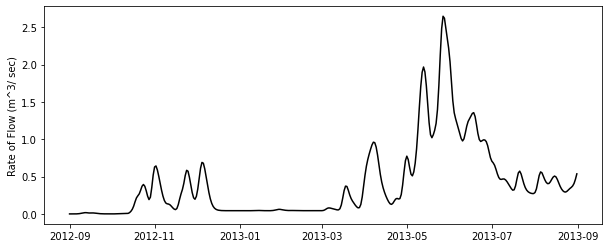

In [9]:
# Get a specific catchment by its ID
idx = [n['id'] for n in stream_flows['nodes']].index(234)
values = [rec['flow'] for rec in stream_flows['nodes'][idx]['dates']]
pyplot.figure(figsize = (10, 4))
pyplot.plot(dates, values, 'k-')
pyplot.ylabel('Rate of Flow (m^3/ sec)')
pyplot.show()

Here's the streamflow through the lowest catchment in our watershed.

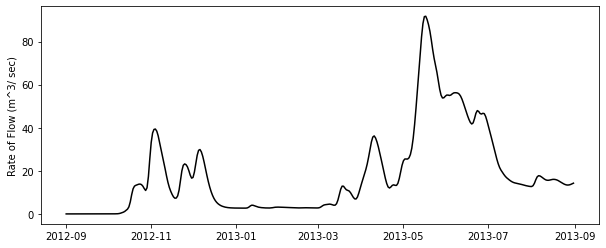

In [10]:
idx = [n['id'] for n in stream_flows['nodes']].index(163)
values = [rec['flow'] for rec in stream_flows['nodes'][idx]['dates']]
pyplot.figure(figsize = (10, 4))
pyplot.plot(dates, values, 'k-')
pyplot.ylabel('Rate of Flow (m^3/ sec)')
pyplot.show()

### Maps of Snowmelt and Actual Evapotranspiration

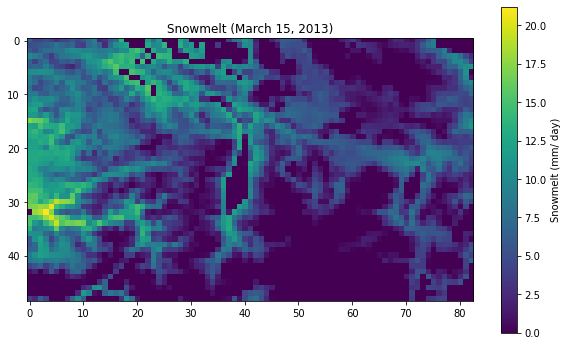

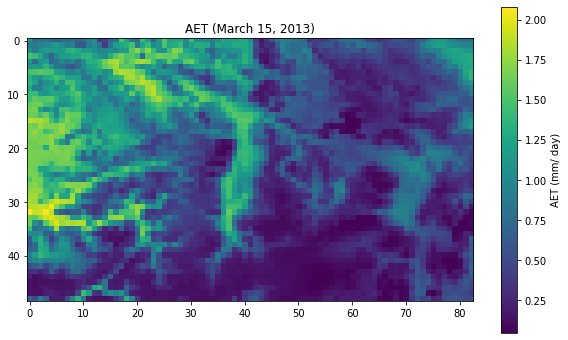

In [11]:
import rasterio as rio

with rio.open('./melt_20130315.tif') as melt:
    pyplot.figure(figsize = (10, 6))
    pyplot.imshow(melt.read(1))
    pyplot.title('Snowmelt (March 15, 2013)')
    cbar = pyplot.colorbar()
    cbar.set_label('Snowmelt (mm/ day)')
    pyplot.show()
    
with rio.open('./aet_20130315.tif') as aet:
    pyplot.figure(figsize = (10, 6))
    pyplot.imshow(aet.read(1))
    pyplot.title('AET (March 15, 2013)')
    cbar = pyplot.colorbar()
    cbar.set_label('AET (mm/ day)')
    pyplot.show()

## References

Cunge, J. A. 1969. On the subject of a flood propagation computation method (Muskingum method). *Journal of Hydraulic Research* 7 (2):205–230.

Maneta, M. P., J. S. Kimball, M. He, N. L. Silverman, B. C. Chaffin, B. Maxwell, S. Ewing, K. Cobourn, and X. Ji. 2020. A satellite-driven hydro-economic model to support agricultural water resources management. *Environmental Modelling & Software.*